In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf 
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv("wine-reviews.csv", usecols=['country', 'description', 'points','price','description','variety','winery'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
#as we can see we have some NaN values
df = df.dropna(subset=['description','points'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


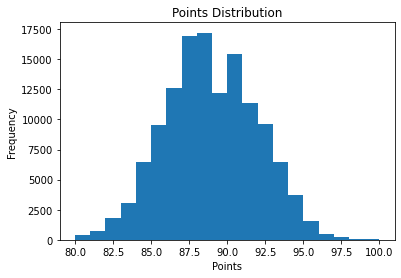

In [ ]:
#plot points to see th distrb
plt.hist(df.points, bins = 20)
plt.title("Points Distribution")
plt.ylabel('Frequency')
plt.xlabel('Points')
plt.show()

In [ ]:
#creating a new column with booleans for true false if its over 90
#then converting bool to int as 1 and 0 is better for our machine
df['label'] = (df.points >=90).astype(int)

In [ ]:
df = df[['description','label']]

In [ ]:
df

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1


In [ ]:
#create splits, cut off 80% for tain, a cut at 90 gives val 10%, leaving 10% for test
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)),int(0.9*len(df))])

In [ ]:
#function that converts each training, validation, and test set DataFrame into a 
#tf.data.Dataset, then shuffles and batches the data.
#below help us convert our split dataframes into a new data set object
#prefetch tries to optimize things

def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  #df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
#now using out split data sets, call out function for each 

train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
#lets look at thhis tensorflow data object
#we can see we have the strings for each item in an array and their corresponding outcome columns below
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'Beautifully packaged and presented, this Sauvignon from the Adriatic flank of Italy offers aromas of exotic fruit, citrus and dried herbs. This expression of the variety is less vibrant than others but does offer an easy, no-fuss approach overall.',
        b"Smells and tastes not quite ripe. Now that the wine is softening and resolving at the age of 3-1/2 years, it's showing a streak of veggie green behind the cherries.",
        b'Now managed organically, this estate has produced a light, fruity wine. Fresh red berries are sustained by a firm tannin edge that offers a solid base for the fruitiness and acidity. Drink from 2017.',
        ...,
        b'This Riserva Brunello delivers savory, brambly characteristics of moist earth and pressed blue flowers backed by forest berry and black cherry flavors. The mouthfeel is compact and clean with crisp acidity on the close.',
        b"This tight and tannic Cab Franc tastes of cranb

In [ ]:
#above we imported tensorflow hub, which is actually a repo of trained machine learning models
#but we need to use text embedding. This will help turn our description strings into numbers

#nnlm-en-dim50 
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype = tf.string, trainable =True)

In [ ]:
#we can see that this transformed our data into and string into a vector containing only numbers
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 5.3276008e-01, -2.2902226e-01,  1.5913340e-01, ...,
         1.0663009e-02, -1.1635106e-01, -4.8939746e-02],
       [ 1.3744229e-01, -3.3792894e-05, -1.5971489e-01, ...,
        -2.9535983e-02, -2.3316525e-01,  2.5410268e-01],
       [ 4.9700704e-01, -3.5439655e-01,  6.3176423e-02, ...,
         1.3957492e-01, -1.2752379e-01, -1.5503186e-01],
       ...,
       [ 3.6449489e-01, -1.9288206e-01,  1.5531754e-01, ...,
         1.6227740e-01, -3.6645615e-01, -1.0028802e-02],
       [ 3.1297913e-01, -1.4213274e-01,  2.9126081e-01, ...,
         3.5856953e-03, -1.6490947e-01, -6.8789534e-02],
       [ 3.4116271e-01, -1.0759054e-01, -2.0987935e-01, ...,
        -9.9448353e-02, -8.1400402e-02, -9.1480292e-02]], dtype=float32)>

In [ ]:
#create the model
model = tf.keras.Sequential()
#add in our first layer to transform the strings into text
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
#now compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                                                   loss = tf.keras.losses.BinaryFocalCrossentropy(), 
                                                   metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

102/102 [==============================] - 2s 13ms/step - loss: 0.1825 - accuracy: 0.3789


[0.1825166493654251, 0.3788951337337494]

In [ ]:
model.evaluate(val_data)

13/13 [==============================] - 0s 13ms/step - loss: 0.1823 - accuracy: 0.3823


[0.18234916031360626, 0.38231900334358215]

In [ ]:
#above is not that great, so lets train it 
history = model.fit(train_data, epochs=5,validation_data=val_data)

Epoch 1/5
102/102 [==============================] - 59s 563ms/step - loss: 0.1621 - accuracy: 0.6067 - val_loss: 0.1348 - val_accuracy: 0.7372
Epoch 2/5
102/102 [==============================] - 58s 567ms/step - loss: 0.1277 - accuracy: 0.7456 - val_loss: 0.1052 - val_accuracy: 0.8182
Epoch 3/5
102/102 [==============================] - 55s 543ms/step - loss: 0.1089 - accuracy: 0.8048 - val_loss: 0.0979 - val_accuracy: 0.8257
Epoch 4/5
102/102 [==============================] - 55s 539ms/step - loss: 0.0983 - accuracy: 0.8303 - val_loss: 0.0967 - val_accuracy: 0.8310
Epoch 5/5
102/102 [==============================] - 56s 546ms/step - loss: 0.0920 - accuracy: 0.8445 - val_loss: 0.0974 - val_accuracy: 0.8308


In [ ]:
#overfitting the model, is when your model is very good at analyzing the training data, but not good at being generalized and 
#applied to other data sets, we can see this happened above because our validation loss actually goes up, not good

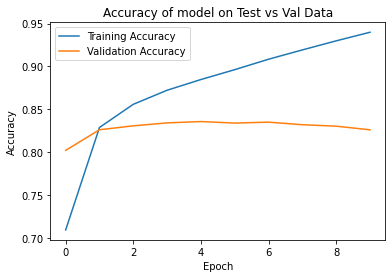

In [ ]:
#lets plot our accuracy our our training data versus our validation data set
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy of model on Test vs Val Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#From the above, we can see that the accuracy of our Validation data doesnt really improve,
#so our model has been over fitted, 
#now lets look at the loss

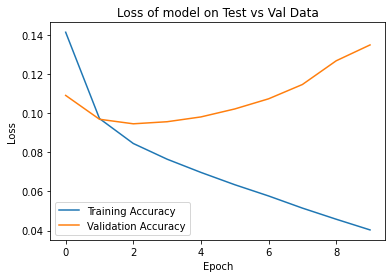

In [ ]:
#lets plot our accuracy our our training data versus our validation data set
plt.plot(history.history['loss'], label = 'Training Accuracy')
plt.plot(history.history['val_loss'], label = 'Validation Accuracy')
plt.title('Loss of model on Test vs Val Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

As we can see from the above in both accuracy and loss our model is good at the training data but isnt generalizable, bc the val info isnt good

one way we can fix it is by adding a dropout to our model, see model adds where dropout layer is now included above. Helps add soem randomness to see where stuff isnt working

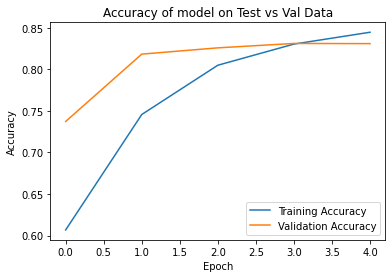

In [ ]:
#after adding in the dropout layers above we now have the below
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy of model on Test vs Val Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#now lets see how our model is with our test data 
model.evaluate(test_data)

13/13 [==============================] - 2s 118ms/step - loss: 0.0981 - accuracy: 0.8317


[0.09807004779577255, 0.8317433595657349]